In [1]:
import os
import wandb
import yaml
import torch
from torch.nn.functional import one_hot
from torch.utils.data import TensorDataset
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning.loggers import WandbLogger
from ccbm.utils import randomize_class, load_data, RandomSamplerClassBatch, save_set_c_and_cf, FEATURE_NAMES, DATASET, CLASS_TO_VISUALISE, print_concept_importance
from ccbm.models import (StandardE2E, StandardCBM, Oracle, 
                         CounterfactualCBM_V3, CounterfactualCBM_V3_1,
                         VAE_CF, CCHVAE, ConceptVCNet)
import math
import numpy as np
import pytorch_lightning as pl
from sklearn.metrics import roc_auc_score
from ccbm.metrics import (variability, 
                          difference_over_union, 
                          intersection_over_union, 
                          cf_in_distribution, distance_train)
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


from train import train_model, train_oracle

In [2]:
# Initialize wandb
wandb.login()

run = wandb.init(dir='./wandb')
wandb_logger = WandbLogger()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gdominici (acbm). Use `wandb login --relogin` to force relogin
wandb: WARNING Path ./wandb/wandb/ wasn't writable, using system temp directory.
wandb: WARNING Path ./wandb/wandb/ wasn't writable, using system temp directory


There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


In [3]:
# Get config variables
seed = 0
batch_size = 1024
dataset_name = 'dsprites'
model = 'CFCBM'
emb_size = 128
device = accelerator = 'cpu'
learning_rate = 0.005
epochs = 75
fold = 0

# Set seed
seed_everything(seed, workers=True)

`pytorch_lightning.utilities.seed.seed_everything` has been deprecated in v1.8.0 and will be removed in v1.10.0. Please use `lightning_lite.utilities.seed.seed_everything` instead.
Global seed set to 0


0

# dSprites

### Saving image embeddings

In [ ]:
# !python3 experiments/dsprites/save_embeddings.py

### Creating directories

In [ ]:
# creates directory for results
results_root_dir = f"./results/"
os.makedirs(results_root_dir, exist_ok=True)
results_dir = f"./results/{dataset_name}/"
os.makedirs(results_dir, exist_ok=True)
figures_dir = f"./results/{dataset_name}/figures/"
os.makedirs(figures_dir, exist_ok=True)
log_dir = f"./results/{dataset_name}/logs/"
os.makedirs(log_dir, exist_ok=True) 

### Loading data

In [ ]:
# Load train data
X, c, y = load_data(dataset_name)
if len(y.shape) == 1:
    y = y.unsqueeze(1)
    # Unique [concepts, labels]
    c_cf_set = torch.unique(torch.cat((c, y), dim=-1), dim=0)
    concept_labels = c_cf_set[:, -1]
    c_cf_set = c_cf_set[:, :-1]
else:
    c_cf_set = torch.unique(torch.cat((c, torch.argmax(y, dim=-1).unsqueeze(-1)), dim=-1), dim=0)
    concept_labels = c_cf_set[:, -1]
    c_cf_set = c_cf_set[:, :-1]
    concept_labels = one_hot(concept_labels.long(), num_classes=y.shape[1]).float()

# Load test data
X_test, c_test, y_test = load_data(dataset_name, split='test')
if len(y_test.shape) == 1:
    y_test = y_test.unsqueeze(1)

### Selecting model

In [ ]:
# Define models
models = {
            'Oracle': Oracle(),
            'DeepNN': StandardE2E(X.shape[1], y.shape[1], emb_size, learning_rate),
            'StandardCBM': StandardCBM(X.shape[1], c.shape[1], y.shape[1], emb_size, learning_rate, bool_concepts=True, deep=False),
            'CFCBM': CounterfactualCBM_V3(X.shape[1], c.shape[1], y.shape[1], emb_size, c_cf_set, concept_labels, learning_rate=learning_rate, resample=0, bernulli=False, deep=False, reconstruction=False),
            'VAECF': (StandardCBM(X.shape[1], c.shape[1], y.shape[1], emb_size, learning_rate, bool_concepts=True, deep=True), 
                      VAE_CF(c.shape[1], y.shape[1], emb_size, None, learning_rate)),
            'CCHVAE': (StandardCBM(X.shape[1], c.shape[1], y.shape[1], emb_size, learning_rate, bool_concepts=True, deep=True),
                       CCHVAE(c.shape[1], y.shape[1], emb_size, None, learning_rate)),
            'VCNET': ConceptVCNet(X.shape[1], c.shape[1], y.shape[1], emb_size, learning_rate, bool_concepts=True, deep=True),
            'BayCon': StandardCBM(X.shape[1], c.shape[1], y.shape[1], emb_size, learning_rate, bool_concepts=True, deep=True),
        }
net = models[model]

### Setting up dataloader

In [ ]:
# Create DataLoader
train_data = TensorDataset(X, c, y)
train_dl = torch.utils.data.DataLoader(train_data, batch_sampler=torch.utils.data.BatchSampler(RandomSamplerClassBatch(y, batch_size=batch_size, replacement=False), batch_size=batch_size, drop_last=True), pin_memory=True)
test_data = TensorDataset(X_test, c_test, y_test)
test_dl = torch.utils.data.DataLoader(test_data, batch_sampler=torch.utils.data.BatchSampler(RandomSamplerClassBatch(y_test, batch_size=batch_size, replacement=False), batch_size=batch_size,  drop_last=True), pin_memory=True)

### Traing the model

In [ ]:
net = train_model(net, epochs, learning_rate, seed, train_dl, test_dl, results_dir, accelerator, wandb_logger)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
Global seed set to 0


Running CounterfactualCBM_V3(
  (cross_entropy): CrossEntropyLoss()
  (bce): BCELoss()
  (bce_log): BCEWithLogitsLoss()
  (model): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
  (encoder): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (relation_classifiers): Sequential(
    (0): Linear(in_features=128, out_features=7, bias=True)
  )
  (reasoner): Sequential(
    (0): Linear(in_features=7, out_features=2, bias=True)
  )
  (classification_loss): BCELoss()
  (concept_mean_predictor): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): LeakyReLU(negative_s


   | Name                       | Type              | Params
------------------------------------------------------------------
0  | cross_entropy              | CrossEntropyLoss  | 0     
1  | bce                        | BCELoss           | 0     
2  | bce_log                    | BCEWithLogitsLoss | 0     
3  | model                      | Sequential        | 82.4 K
4  | encoder                    | Sequential        | 82.2 K
5  | relation_classifiers       | Sequential        | 903   
6  | reasoner                   | Sequential        | 16    
7  | concept_mean_predictor     | Sequential        | 33.0 K
8  | concept_var_predictor      | Sequential        | 33.0 K
9  | concept_mean_z3_predictor  | Sequential        | 34.2 K
10 | concept_var_z3_predictor   | Sequential        | 34.2 K
11 | concept_mean_qz3_predictor | Sequential        | 34.4 K
12 | concept_var_qz3_predictor  | Sequential        | 34.4 K
13 | concept_predictor          | Sequential        | 17.4 K
-----------------

Sanity Checking: 0it [00:00, ?it/s]

The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=75` reached.


Best train acc: 0.9738578796386719, Epoch: 56


### Testing the model and saving the outputs

In [ ]:
# Testing the model 
c_preds_total = torch.empty(0, train_dl.dataset[0][1].shape[-1])
c_total = torch.empty(0, train_dl.dataset[0][1].shape[-1])
y_preds_total = torch.empty(0, train_dl.dataset[0][-1].shape[-1])
y_total = torch.empty(0, train_dl.dataset[0][-1].shape[-1])
y_cf_total = torch.empty(0, train_dl.dataset[0][-1].shape[-1])
y_cf_target_total = torch.empty(0, train_dl.dataset[0][-1].shape[-1])
c_cf_total = torch.empty(0, train_dl.dataset[0][1].shape[-1])
z2_total = torch.empty(0, net.emb_size)
z3_total = torch.empty(0, net.emb_size)

for X_test, c_test, y_test in test_dl:
    y_prime = randomize_class(y_test, include=False)
    if y_test.shape[-1] == 1:
        y_prime = None
    (c_preds, y_preds, explanations,
    c_cf, y_cf, y_cf_target, explanation_cf, 
    p_z2, qz2_x, pz3_z2_c_y, qz3_z2_c_y_y_prime,
    pcprime_z3, py_c, py_c_cf, pc_z2, c_cf_true, weights, z2, z3, c_pred_d) = net.forward(X_test, test=True, y_prime=y_prime, explain=True, include=False, inference=True)

    c_preds_total = torch.cat((c_preds_total, c_preds), dim=0)
    c_total = torch.cat((c_total, c_test), dim=0)
    y_preds_total = torch.cat((y_preds_total, y_preds), dim=0)
    y_total = torch.cat((y_total, y_test), dim=0)
    y_cf_total = torch.cat((y_cf_total, y_cf), dim=0)
    y_cf_target_total = torch.cat((y_cf_target_total, y_cf_target), dim=0)
    c_cf_total = torch.cat((c_cf_total, c_cf), dim=0)
    z2_total = torch.cat((z2_total, z2), dim=0)
    z3_total = torch.cat((z3_total, z3), dim=0)


### Computing metrics

In [ ]:
# Compute metrics
concept_accuracy = roc_auc_score(c_total.cpu(), c_preds_total.detach().cpu())
print('ROC AUC Concept Accuracy (%): ', concept_accuracy*100)
concept_acc = (c_preds_total > 0.5).float().eq(c_total).float().all(dim=-1).float().mean().item()
print('Entire Concept Accuracy (%): ', concept_acc*100)
task_accuracy = roc_auc_score(y_total.cpu(), y_preds_total.detach().cpu())
print('ROC AUC Task Accuracy (%): ', task_accuracy*100)
task_cf_accuracy = roc_auc_score(y_cf_target_total.squeeze().cpu(), y_cf_total.detach().cpu())
print('Validity (%): ', task_cf_accuracy*100)
cf_variability = variability(c_cf_total.cpu(), c_preds_total.cpu())
print('Variability: ', cf_variability)
cf_iou = intersection_over_union(c_cf_total.cpu(), c_total.cpu())
print('IOU (%): ', cf_iou*100)
mean_distance_train = distance_train(c_cf_total.cpu(), c_cf_set.cpu(), y_cf_total.detach().cpu(), concept_labels.cpu()).item() / c_cf_total.shape[-1]
print('Proximity (%): ', mean_distance_train*100)

pdist = torch.nn.PairwiseDistance(p=2)
hamming_distance = torch.norm((c_preds_total>0.5).float().cpu() - (c_cf_total>0.5).float().cpu(), p=0, dim=-1).mean().item() 
oracle = Oracle()
oracle_results, oracle = train_oracle(oracle, test_dl, c_cf_set, concept_labels, wandb_logger)
oracle_sparsity = oracle_results['hamming_distance']
delta_sparsity = abs(hamming_distance - oracle_sparsity) / c_cf_total.shape[-1]
print('Delta Sparsity (%): ', delta_sparsity*100)

cf_time_total, cf_found = net.counterfactual_times(test_dl, accelerator, rerun=False)
print('CF Time: ', cf_time_total)

ROC AUC Concept Accuracy (%):  97.85359784937881
Entire Concept Accuracy (%):  79.00390625
ROC AUC Task Accuracy (%):  99.35452363881126
Validity (%):  100.0
Variability:  0.5714285714285714
IOU (%):  56.00000000000001
Proximity (%):  0.9835379464285714
Delta Sparsity (%):  4.338727678571429
CF Time:  0.0291440486907959


In [ ]:
save_set_c_and_cf(c_preds_total, y_preds_total, y_cf_total, c_cf_total, model, fold, log_dir)

### Computing feature importance

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


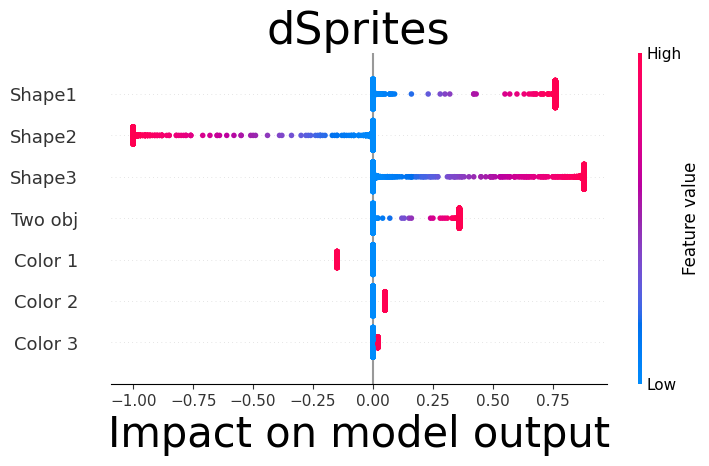

In [ ]:
c_preds_total_train = torch.empty(0, train_dl.dataset[0][1].shape[-1])
for X_train, c_train, y_train in train_dl:
    
    y_prime = randomize_class(y_test, include=False)
    if y_train.shape[-1] == 1:
        y_prime = None
    (c_preds, y_preds, explanations,
    c_cf, y_cf, y_cf_target, explanation_cf, 
    p_z2, qz2_x, pz3_z2_c_y, qz3_z2_c_y_y_prime,
    pcprime_z3, py_c, py_c_cf, pc_z2, c_cf_true, weights, z2, z3, c_pred_d) = net.forward(X_train, test=True, y_prime=y_prime, explain=True, include=False, inference=True)

    if not net.bool_concepts:
        c_preds = torch.sigmoid(c_preds)

    c_preds_total_train = torch.cat((c_preds_total_train, c_preds), dim=0)

idx = CLASS_TO_VISUALISE[str(c_preds_total_train.shape[-1])]
print_concept_importance(net, idx, c_preds_total_train, c_preds_total, show=True)

### Computing mesures sampling more than once

In [ ]:
n_times_list = [5, 10, 100]
for n in n_times_list: 
    print(f'--------------{n} SAMPLES-----------------')
    c_preds_total = torch.empty(0, train_dl.dataset[0][1].shape[-1])
    c_total = torch.empty(0, train_dl.dataset[0][1].shape[-1])
    y_preds_total = torch.empty(0, train_dl.dataset[0][-1].shape[-1])
    y_total = torch.empty(0, train_dl.dataset[0][-1].shape[-1])
    for X_test, c_test, y_test in test_dl:
        y_prime = randomize_class(y_test, include=False)
        (c_preds, y_preds, explanations,
        c_cf, y_cf, y_cf_target, explanation_cf, 
        p_z2, qz2_x, pz3_z2_c_y, qz3_z2_c_y_y_prime,
        pcprime_z3, py_c, py_c_cf, pc_z2, c_cf_true, weights, z2, z3, c_pred_d) = net.forward(X_test, test=True, y_prime=y_prime, explain=True, include=False, resample=n)

        c_preds_total = torch.cat((c_preds_total, c_preds), dim=0)
        c_total = torch.cat((c_total, c_test), dim=0)
        y_preds_total = torch.cat((y_preds_total, y_preds), dim=0)
        y_total = torch.cat((y_total, y_test), dim=0)

    cf_time, cf_found, cf, c_preds_total, y_cf_total = net.counterfactual_times(test_dl, accelerator, rerun=False, n_times=n, return_cf=True)
    print(f'CF Time {n} samples: ', cf_time)
    
    cf_variability = variability(cf.cpu(), c_preds_total.cpu())
    print(f'Variability {n} samples: ', cf_variability)
    cf_iou = intersection_over_union(cf.cpu(), c_preds_total.cpu())
    print(f'IOU {n} samples (%): ', cf_iou*100)
    mean_distance_train = distance_train(cf.cpu(), c_cf_set.cpu(), y_cf_total.detach().cpu(), concept_labels.cpu()).item() / cf.shape[-1]
    print(f'Proximity {n} samples (%): ', mean_distance_train*100)
    hamming_distance = torch.norm((c_preds_total>0.5).float().cpu() - (cf>0.5).float().cpu(), p=0, dim=-1).mean().item() 
    delta_sparsity = abs(hamming_distance - oracle_sparsity) / c_cf_total.shape[-1]
    print(f'Delta Sparsity {n} samples (%): ', delta_sparsity*100)

--------------5 SAMPLES-----------------
CF Time 5 samples:  0.05852007865905762
Variability 5 samples:  1.3243243243243243
IOU 5 samples (%):  65.38461538461539
Proximity 5 samples (%):  1.4090401785714286
Delta Sparsity 5 samples (%):  4.310825892857143
--------------10 SAMPLES-----------------
CF Time 10 samples:  0.0797576904296875
Variability 10 samples:  1.3333333333333333
IOU 10 samples (%):  58.490566037735846
Proximity 10 samples (%):  1.3950892857142858
Delta Sparsity 10 samples (%):  4.401506696428571
--------------100 SAMPLES-----------------
CF Time 100 samples:  0.543816328048706
Variability 100 samples:  1.3714285714285714
IOU 100 samples (%):  62.745098039215684
Proximity 100 samples (%):  1.5904017857142856
Delta Sparsity 100 samples (%):  4.408482142857143


### Computing metrics for task driven interventions

In [ ]:
p_list = [0.1, 0.2, 0.5, 1.0]
for p in p_list:
    print(f'--------------{p} NOISE LEVEL-----------------')
    c_preds_total_noise = torch.empty(0, train_dl.dataset[0][1].shape[-1])
    c_total = torch.empty(0, train_dl.dataset[0][1].shape[-1])
    y_preds_total = torch.empty(0, train_dl.dataset[0][-1].shape[-1])
    y_prime_total = torch.empty(0, train_dl.dataset[0][-1].shape[-1])
    y_cf_total = torch.empty(0, train_dl.dataset[0][-1].shape[-1])
    c_cf_total = torch.empty(0, train_dl.dataset[0][1].shape[-1])
    for X_test, c_test, y_test in test_dl:
        y_prime = y_test.clone()
        y_cf_logits, c_cf, y_preds, c_preds = net.predict_counterfactuals(
            X_test, y_prime=y_prime, resample=1, return_cf=True, auto_intervention=p, full=True
        )

        c_preds_total_noise = torch.cat((c_preds_total_noise, c_preds), dim=0)
        c_total = torch.cat((c_total, c_test), dim=0)
        y_preds_total = torch.cat((y_preds_total, y_preds), dim=0)
        y_prime_total = torch.cat((y_prime_total, y_test), dim=0)
        y_cf_total = torch.cat((y_cf_total, y_cf_logits), dim=0)
        c_cf_total = torch.cat((c_cf_total, c_cf), dim=0)
    
    task_accuracy = roc_auc_score(y_prime_total.cpu(), y_preds_total.detach().cpu())
    print(f'ROC AUC Task Accuracy {p} noise level (%): ', task_accuracy*100)
    task_accuracy_cf = roc_auc_score(y_prime_total.cpu(), y_cf_total.detach().cpu())
    print(f'ROC AUC Task Accuracy CF {p} noise level (%): ', task_accuracy_cf*100)
    cf_concept_acc = (c_cf_total > 0.5).float().eq(c_total).float().all(dim=-1).float().mean().item()
    print(f'Accuracy Intervention {p} noise level (%): ', cf_concept_acc*100)
    mean_distance_train = distance_train(c_cf_total.cpu(), c_cf_set.cpu(), y_cf_total.detach().cpu(), concept_labels.cpu()).item() / c_cf_total.shape[-1]
    print(f'Proximity Intervention {p} noise level (%): ', mean_distance_train*100)

--------------0.1 NOISE LEVEL-----------------
ROC AUC Task Accuracy 0.1 noise level (%):  98.45068273239454
ROC AUC Task Accuracy CF 0.1 noise level (%):  100.0
Accuracy Intervention 0.1 noise level (%):  79.39453125
Proximity Intervention 0.1 noise level (%):  0.32784598214285715
--------------0.2 NOISE LEVEL-----------------
ROC AUC Task Accuracy 0.2 noise level (%):  67.41483394068133
ROC AUC Task Accuracy CF 0.2 noise level (%):  100.0
Accuracy Intervention 0.2 noise level (%):  79.443359375
Proximity Intervention 0.2 noise level (%):  0.4045758928571429
--------------0.5 NOISE LEVEL-----------------
ROC AUC Task Accuracy 0.5 noise level (%):  78.32774817337803
ROC AUC Task Accuracy CF 0.5 noise level (%):  99.99468952004248
Accuracy Intervention 0.5 noise level (%):  79.345703125
Proximity Intervention 0.5 noise level (%):  0.34877232142857145
--------------1.0 NOISE LEVEL-----------------
ROC AUC Task Accuracy 1.0 noise level (%):  0.6957549475907374
ROC AUC Task Accuracy CF 1.0

# dSprites with high correlation between color and task

## Counterfactual CBM 

In [ ]:
# !python3 experiments/dsprites/save_embeddings_mod.py

In [4]:
model = 'CFCBM'

# Set seed
seed_everything(seed, workers=True)

Global seed set to 0


0

### Loading modified data

In [5]:
# Load train data
dataset_name = 'dsprites_mod'
X, c, y = load_data(dataset_name)
if len(y.shape) == 1:
    y = y.unsqueeze(1)
    # Unique [concepts, labels]
    c_cf_set = torch.unique(torch.cat((c, y), dim=-1), dim=0)
    concept_labels = c_cf_set[:, -1]
    c_cf_set = c_cf_set[:, :-1]
else:
    c_cf_set = torch.unique(torch.cat((c, torch.argmax(y, dim=-1).unsqueeze(-1)), dim=-1), dim=0)
    concept_labels = c_cf_set[:, -1]
    c_cf_set = c_cf_set[:, :-1]
    concept_labels = one_hot(concept_labels.long(), num_classes=y.shape[1]).float()

# Load test data
X_test, c_test, y_test = load_data(dataset_name, split='test')
if len(y_test.shape) == 1:
    y_test = y_test.unsqueeze(1)

### Creating directories for results

In [6]:
# creates directory for results
results_root_dir = f"./results/"
os.makedirs(results_root_dir, exist_ok=True)
results_dir = f"./results/{dataset_name}/"
os.makedirs(results_dir, exist_ok=True)
figures_dir = f"./results/{dataset_name}/figures/"
os.makedirs(figures_dir, exist_ok=True)
log_dir = f"./results/{dataset_name}/logs/"
os.makedirs(log_dir, exist_ok=True) 

### Setting up dataloader

In [7]:
# Create DataLoader
train_data = TensorDataset(X, c, y)
train_dl = torch.utils.data.DataLoader(train_data, batch_sampler=torch.utils.data.BatchSampler(RandomSamplerClassBatch(y, batch_size=batch_size, replacement=False), batch_size=batch_size, drop_last=True), pin_memory=True)
test_data = TensorDataset(X_test, c_test, y_test)
test_dl = torch.utils.data.DataLoader(test_data, batch_sampler=torch.utils.data.BatchSampler(RandomSamplerClassBatch(y_test, batch_size=batch_size, replacement=False), batch_size=batch_size,  drop_last=True), pin_memory=True)

### Choosing and training the model

In [8]:
# Define models
models = {
            'Oracle': Oracle(),
            'DeepNN': StandardE2E(X.shape[1], y.shape[1], emb_size, learning_rate),
            'StandardCBM': StandardCBM(X.shape[1], c.shape[1], y.shape[1], emb_size, learning_rate, bool_concepts=True, deep=False),
            'CFCBM': CounterfactualCBM_V3(X.shape[1], c.shape[1], y.shape[1], emb_size, c_cf_set, concept_labels, learning_rate=learning_rate, resample=0, bernulli=False, deep=False, reconstruction=False),
            'VAECF': (StandardCBM(X.shape[1], c.shape[1], y.shape[1], emb_size, learning_rate, bool_concepts=True, deep=True), 
                      VAE_CF(c.shape[1], y.shape[1], emb_size, None, learning_rate)),
            'CCHVAE': (StandardCBM(X.shape[1], c.shape[1], y.shape[1], emb_size, learning_rate, bool_concepts=True, deep=True),
                       CCHVAE(c.shape[1], y.shape[1], emb_size, None, learning_rate)),
            'VCNET': ConceptVCNet(X.shape[1], c.shape[1], y.shape[1], emb_size, learning_rate, bool_concepts=True, deep=True),
            'BayCon': StandardCBM(X.shape[1], c.shape[1], y.shape[1], emb_size, learning_rate, bool_concepts=True, deep=True),
        }
net = models[model]
net = train_model(net, 90, learning_rate, seed, train_dl, test_dl, results_dir, accelerator, wandb_logger)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
Global seed set to 0


Running CounterfactualCBM_V3(
  (cross_entropy): BCEWithLogitsLoss()
  (bce): BCELoss()
  (bce_log): BCEWithLogitsLoss()
  (model): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
  (encoder): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (relation_classifiers): Sequential(
    (0): Linear(in_features=128, out_features=7, bias=True)
  )
  (reasoner): Sequential(
    (0): Linear(in_features=7, out_features=1, bias=True)
  )
  (classification_loss): BCELoss()
  (concept_mean_predictor): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): LeakyReLU(negative_


   | Name                       | Type              | Params
------------------------------------------------------------------
0  | cross_entropy              | BCEWithLogitsLoss | 0     
1  | bce                        | BCELoss           | 0     
2  | bce_log                    | BCEWithLogitsLoss | 0     
3  | model                      | Sequential        | 82.3 K
4  | encoder                    | Sequential        | 82.2 K
5  | relation_classifiers       | Sequential        | 903   
6  | reasoner                   | Sequential        | 8     
7  | concept_mean_predictor     | Sequential        | 33.0 K
8  | concept_var_predictor      | Sequential        | 33.0 K
9  | concept_mean_z3_predictor  | Sequential        | 34.0 K
10 | concept_var_z3_predictor   | Sequential        | 34.0 K
11 | concept_mean_qz3_predictor | Sequential        | 34.2 K
12 | concept_var_qz3_predictor  | Sequential        | 34.2 K
13 | concept_predictor          | Sequential        | 17.4 K
-----------------

Sanity Checking: 0it [00:00, ?it/s]

The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=90` reached.


Best train acc: 0.9216848611831665, Epoch: 88


### Testing the model and saving the output

In [9]:
# Testing the model 
c_preds_total = torch.empty(0, train_dl.dataset[0][1].shape[-1])
c_total = torch.empty(0, train_dl.dataset[0][1].shape[-1])
y_preds_total = torch.empty(0, train_dl.dataset[0][-1].shape[-1])
y_total = torch.empty(0, train_dl.dataset[0][-1].shape[-1])
y_cf_total = torch.empty(0, train_dl.dataset[0][-1].shape[-1])
y_cf_target_total = torch.empty(0, train_dl.dataset[0][-1].shape[-1])
c_cf_total = torch.empty(0, train_dl.dataset[0][1].shape[-1])
z2_total = torch.empty(0, net.emb_size)
z3_total = torch.empty(0, net.emb_size)

for X_test, c_test, y_test in test_dl:
    y_prime = randomize_class(y_test, include=False)
    if y_test.shape[-1] == 1:
        y_prime = None
    (c_preds, y_preds, explanations,
    c_cf, y_cf, y_cf_target, explanation_cf, 
    p_z2, qz2_x, pz3_z2_c_y, qz3_z2_c_y_y_prime,
    pcprime_z3, py_c, py_c_cf, pc_z2, c_cf_true, weights, z2, z3, c_pred_d) = net.forward(X_test, test=True, y_prime=y_prime, explain=True, include=False, inference=True)

    c_preds_total = torch.cat((c_preds_total, c_preds), dim=0)
    c_total = torch.cat((c_total, c_test), dim=0)
    y_preds_total = torch.cat((y_preds_total, y_preds), dim=0)
    y_total = torch.cat((y_total, y_test), dim=0)
    y_cf_total = torch.cat((y_cf_total, y_cf), dim=0)
    y_cf_target_total = torch.cat((y_cf_target_total, y_cf_target), dim=0)
    c_cf_total = torch.cat((c_cf_total, c_cf), dim=0)
    z2_total = torch.cat((z2_total, z2), dim=0)
    z3_total = torch.cat((z3_total, z3), dim=0)


### Computing common metrics

In [10]:
# Compute metrics
concept_accuracy = roc_auc_score(c_total.cpu(), c_preds_total.detach().cpu())
print('ROC AUC Concept Accuracy (%): ', concept_accuracy*100)
concept_acc = (c_preds_total > 0.5).float().eq(c_total).float().all(dim=-1).float().mean().item()
print('Entire Concept Accuracy (%): ', concept_acc*100)
task_accuracy = roc_auc_score(y_total.cpu(), y_preds_total.detach().cpu())
print('ROC AUC Task Accuracy (%): ', task_accuracy*100)
task_cf_accuracy = roc_auc_score(y_cf_target_total.squeeze().cpu(), y_cf_total.detach().cpu())
print('Validity (%): ', task_cf_accuracy*100)
cf_variability = variability(c_cf_total.cpu(), c_preds_total.cpu())
print('Variability: ', cf_variability)
cf_iou = intersection_over_union(c_cf_total.cpu(), c_total.cpu())
print('IOU (%): ', cf_iou*100)
mean_distance_train = distance_train(c_cf_total.cpu(), c_cf_set.cpu(), y_cf_total.detach().cpu(), concept_labels.cpu()).item() / c_cf_total.shape[-1]
print('Proximity (%): ', mean_distance_train*100)

pdist = torch.nn.PairwiseDistance(p=2)
hamming_distance = torch.norm((c_preds_total>0.5).float().cpu() - (c_cf_total>0.5).float().cpu(), p=0, dim=-1).mean().item() 
oracle = Oracle()
oracle_results, oracle = train_oracle(oracle, test_dl, c_cf_set, concept_labels, wandb_logger)
oracle_sparsity = oracle_results['hamming_distance']
delta_sparsity = abs(hamming_distance - oracle_sparsity) / c_cf_total.shape[-1]
print('Delta Sparsity (%): ', delta_sparsity*100)

cf_time_total, cf_found = net.counterfactual_times(test_dl, accelerator, rerun=False)
print('CF Time: ', cf_time_total)

ROC AUC Concept Accuracy (%):  98.3177937914769
Entire Concept Accuracy (%):  79.833984375
ROC AUC Task Accuracy (%):  99.86408792240302
Validity (%):  94.87202721838014
Variability:  0.7916666666666666
IOU (%):  48.275862068965516
Proximity (%):  1.0672433035714286
Delta Sparsity (%):  2.7553013392857144
CF Time:  0.012737035751342773


In [11]:
save_set_c_and_cf(c_preds_total, y_preds_total, y_cf_total, c_cf_total, model, fold, log_dir)

### Computing concept importance

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


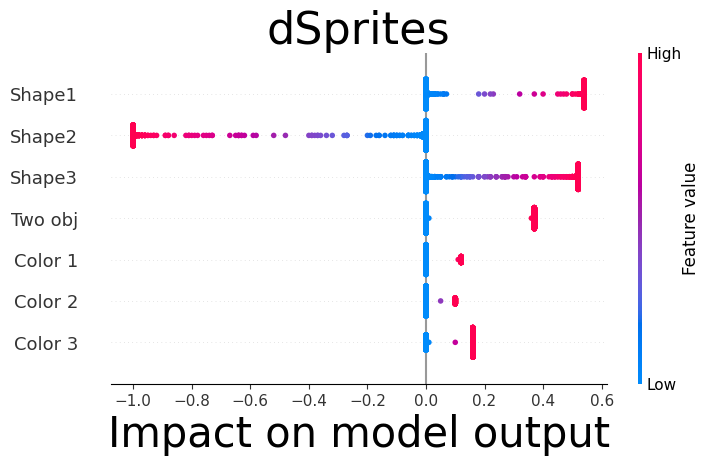

In [12]:
c_preds_total_train = torch.empty(0, train_dl.dataset[0][1].shape[-1])
for X_train, c_train, y_train in train_dl:
    
    y_prime = randomize_class(y_test, include=False)
    if y_train.shape[-1] == 1:
        y_prime = None
    (c_preds, y_preds, explanations,
    c_cf, y_cf, y_cf_target, explanation_cf, 
    p_z2, qz2_x, pz3_z2_c_y, qz3_z2_c_y_y_prime,
    pcprime_z3, py_c, py_c_cf, pc_z2, c_cf_true, weights, z2, z3, c_pred_d) = net.forward(X_train, test=True, y_prime=y_prime, explain=True, include=False, inference=True)

    if not net.bool_concepts:
        c_preds = torch.sigmoid(c_preds)

    c_preds_total_train = torch.cat((c_preds_total_train, c_preds), dim=0)

idx = CLASS_TO_VISUALISE[str(c_preds_total_train.shape[-1])]
print_concept_importance(net, idx, c_preds_total_train, c_preds_total, show=True)

In [13]:
y_preds = net.reasoner(c_preds_total)

identity = torch.Tensor([[0, 0, 1], [0, 0, 1], [1, 0, 0]])
c_preds_total_int = c_preds_total.clone()
c_preds_total_int[:, -3:] = identity[c_preds_total_int[:, -3:].argmax(dim=-1)]

y_preds_int = net.reasoner(c_preds_total_int)
tot = ((y_preds > 0) == (y_preds_int > 0)).float().sum().item()
print('Flipped labels (%): ', (1 - tot/c_preds_total.shape[0])*100)

Flipped labels (%):  0.1953125


## Standard CBM 

### Selecting the model 

In [14]:
model = 'StandardCBM'
seed_everything(seed, workers=True)
net = models[model]

`pytorch_lightning.utilities.seed.seed_everything` has been deprecated in v1.8.0 and will be removed in v1.10.0. Please use `lightning_lite.utilities.seed.seed_everything` instead.
Global seed set to 0


### Training the model 

In [15]:
net = train_model(net, epochs, learning_rate, seed, train_dl, test_dl, results_dir, accelerator, wandb_logger)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


Global seed set to 0
Checkpoint directory ./lightning_logs/boglad0j/checkpoints exists and is not empty.

  | Name                 | Type              | Params
-----------------------------------------------------------
0 | cross_entropy        | BCEWithLogitsLoss | 0     
1 | bce                  | BCELoss           | 0     
2 | bce_log              | BCEWithLogitsLoss | 0     
3 | model                | Sequential        | 82.3 K
4 | encoder              | Sequential        | 82.2 K
5 | relation_classifiers | Sequential        | 903   
6 | reasoner             | Sequential        | 8     
-----------------------------------------------------------
165 K     Trainable params
0         Non-trainable params
165 K     Total params
0.662     Total estimated model params size (MB)


Running StandardCBM(
  (cross_entropy): BCEWithLogitsLoss()
  (bce): BCELoss()
  (bce_log): BCEWithLogitsLoss()
  (model): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
  (encoder): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (relation_classifiers): Sequential(
    (0): Linear(in_features=128, out_features=7, bias=True)
  )
  (reasoner): Sequential(
    (0): Linear(in_features=7, out_features=1, bias=True)
  )
  (classification_loss): BCELoss()
), epochs=75, learning_rate=0.005


Sanity Checking: 0it [00:00, ?it/s]

The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=75` reached.


Best train acc: 0.989919585949183, Epoch: 27


### Testing the model, saving the output and computing metrics

In [16]:
y_preds_total = torch.empty(0, train_dl.dataset[0][-1].shape[-1])
y_total = torch.empty(0, train_dl.dataset[0][-1].shape[-1])
c_preds_total = torch.empty(0, train_dl.dataset[0][1].shape[-1])
c_total = torch.empty(0, train_dl.dataset[0][1].shape[-1])

for X_test, c_test, y_test in test_dl:

    c_preds, y_preds, _ = net.forward(X_test)

    if not net.bool_concepts:
        c_preds = torch.sigmoid(c_preds)

    c_preds_total = torch.cat((c_preds_total, c_preds), dim=0)
    c_total = torch.cat((c_total, c_test), dim=0)
    y_preds_total = torch.cat((y_preds_total, y_preds), dim=0)
    y_total = torch.cat((y_total, y_test), dim=0)

concept_accuracy = roc_auc_score(c_total.cpu(), c_preds_total.detach().cpu())
concept_acc = (c_preds_total > 0.5).float().eq(c_total).float().all(dim=-1).float().mean()
p_c = (c_preds_total > 0.5).float().eq(c_total).float().mean(dim=-1).float().mean()
task_accuracy = roc_auc_score(y_total.cpu(), y_preds_total.detach().cpu())

### Computing concept importance

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


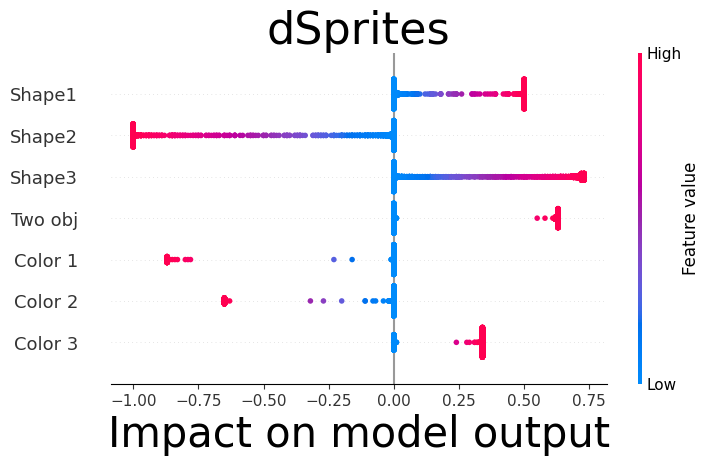

In [17]:
c_preds_total_train = torch.empty(0, train_dl.dataset[0][1].shape[-1])
for X_train, c_train, y_train in train_dl:

    c_preds, y_preds, _ = net.forward(X_train)

    if not net.bool_concepts:
        c_preds = torch.sigmoid(c_preds)

    c_preds_total_train = torch.cat((c_preds_total_train, c_preds), dim=0)

idx = CLASS_TO_VISUALISE[str(c_preds_total_train.shape[-1])]
print_concept_importance(net, idx, c_preds_total_train, c_preds_total, show=True)

#### You can notice a greater importance given by this model to colors concepts compared to the Counterfactual CBM.

In [18]:
y_preds = net.reasoner(c_preds_total)

identity = torch.Tensor([[0, 0, 1], [0, 0, 1], [1, 0, 0]])
c_preds_total_int = c_preds_total.clone()
c_preds_total_int[:, -3:] = identity[c_preds_total_int[:, -3:].argmax(dim=-1)]

y_preds_int = net.reasoner(c_preds_total_int)
tot = ((y_preds > 0) == (y_preds_int > 0)).float().sum().item()
print('Flipped labels (%): ', (1 - tot/c_preds_total.shape[0])*100)

Flipped labels (%):  16.50390625
